```
This notebook sets up and runs a Cartesian analog to the Galewsky
2004 test case, defined in the paper 
"An initial-value problem for testing numerical models of the global
shallow-water equations"

Copyright (C) 2016, 2017, 2018  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
import scipy as scipy
from scipy import integrate
from matplotlib import animation, rc
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import os
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import datetime
import sys

from importlib import reload

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

#Set large figure sizes
#rc('figure', figsize=(16.0, 12.0))
#rc('animation', html='html5')
plt.rcParams["animation.html"] = "jshtml"

#Import our simulator
from SWESimulators import FBL, CTCS, KP07, CDKLM16, PlotHelper, Common, IPythonMagic
#Import initial condition and bathymetry generating functions:
from SWESimulators.BathymetryAndICs import *

In [2]:
#%setup_logging --out galewsky.log
%cuda_context_handler gpu_ctx

# Galewsky 2004 test case

**Videos can be found at** http://gpu-ocean.met.no:9000/gpu_ocean/galewsky_20190212/

The test case is defined for spheric global shallow water models representing atmospheric flow, in the paper 
```
Joseph Galewsky, Richard K. Scott & Lorenzo M. Polvani (2004) An initial-
value problem for testing numerical models of the global shallow-water equations, Tellus A:
Dynamic Meteorology and Oceanography, 56:5, 429-440, DOI: 10.3402/tellusa.v56i5.14436
```
which can be found here: https://doi.org/10.3402/tellusa.v56i5.14436

The case describes a smooth yet moving around the globe initialized with a balanced $\eta$-field which describes a steady-state solution.
A perturbation is then added to the initial conditions, which generates turbulent solutions for the inviscid case, and a well-defined reference solution for the viscid case.

Three tests are created from this case:

**Test 1** Steady-state jet - The jet without a perturbation should indeed describe a steady state.

**Test 2** Short term effect of the perturbation - A perturbation in form of a $\eta$-bump is added to the initial conditions. By looking at a cross-section at $x = x_0$, this disturbance should result in a gravitational wave towards north and south, which should disappear and leave the state appearantly similar to the steady state.

**Test 3** Long term turbulent effects of the perturbation - The perturbation results in long-term instabilities in the jet.



# Rewriting the case to Cartesian coordinates

The first goal is to rewrite the test case to a two dimensional Cartesian grid, for which our simulators are written.
We aim to use the $\beta$-model for modelling the Coriolis effect.

The domain should be periodic in east-west, and open (flow relaxation) in north/south.


## Investigating the initial conditions based on spheric coordinates



/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.463368e-04
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 4.082669e-04
  AccuracyWarning)


Text(0, 0.5, 'u0')

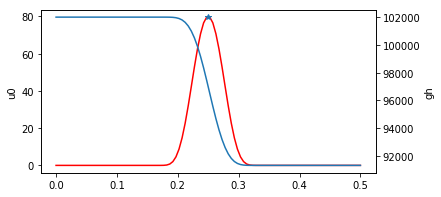

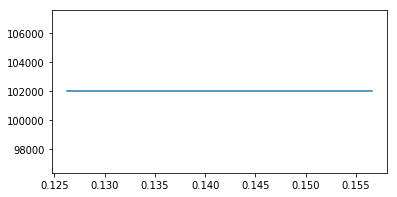

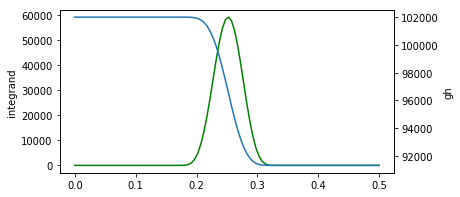

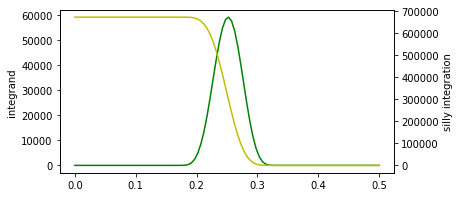

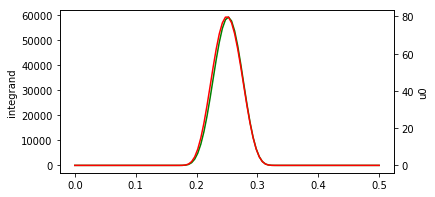

In [3]:
# global constants
OMEGA = 7.292e-5 # 1/s  - Angular rotation speed of the earth
GRAVITY = 9.80616 # m/s^2 - gravitational acceleration
RADIUS = 6.37122e6 # m - radius of the Earth
 
# parameters
u_max = 80 #m/s
phi_0 = np.pi/7.0
phi_1 = np.pi/2.0 - phi_0
e_n = np.exp( -4/(phi_1 - phi_0)**2)
h_0_guestimate = 10.4e3 # m  - global mean layer depth - estimated from the plot in Galewsky Fig. 1.

midpoint_phi = np.pi/4



# Different Coriolis models
def spheric_coriolis(lat):
    return 2*OMEGA*np.sin(lat)

def const_coriolis(lat):
    return 2*OMEGA*np.sin(midpoint_phi)*np.ones_like(lat)

def beta_coriolis(lat):
    return spheric_coriolis(phi_0) + (lat-phi_0)*(spheric_coriolis(phi_1) - spheric_coriolis(phi_0))/(phi_1 - phi_0)

# tangens corresponding to the beta model
def beta_tan(lat):
    return np.tan(phi_0) + (lat - phi_0)*(np.tan(phi_1) - np.tan(phi_0))/(phi_1 - phi_0)


# smooth step function
def smoothstep(x,loc, slope=1):
    return np.exp(slope*x)/(np.exp(loc*slope) + np.exp(slope*x))


# The initialization function for u
def init_u_scalar(lat):
    return (u_max/e_n) *np.exp(1/((lat-phi_0)*(lat-phi_1)))

def init_u(lat):
    steps = smoothstep(lat, phi_0, slope=50)*(1-smoothstep(lat, phi_1, slope=50))
    if np.isscalar(lat):
        return steps*init_u_scalar(lat)
    else:
        
        out = np.zeros_like(lat)
        for i in range(len(lat)):
            if lat[i] > phi_0 and lat[i] <= phi_1:
                out[i] = init_u_scalar(lat[i])
        return steps*out
    

# Integrand for initialization of h
def init_h_integrand(lat, coriolis_function, tan_function):
    return RADIUS*init_u(lat)*(coriolis_function(lat) + (tan_function(lat)/RADIUS)*init_u(lat))

phi = np.linspace(0, np.pi/2, num=100)
u0 = np.zeros_like(phi)
u0 = init_u(phi)

def generate_gh0(lat, coriolis_function, tan_function, lat_0, h_0):
    gh0 = np.zeros_like(lat)

    for i in range(lat.size):
        gh0[i] = GRAVITY*h_0 - scipy.integrate.quadrature(init_h_integrand, phi_0, lat[i], 
                                                          args=(coriolis_function, tan_function))[0]

    # For some wierd reason, the integration fails for the southmost value where the expression for
    # u is used.
    # This is a dirty fix:
    #for i in range(gh0.size):
    #    if np.isnan(gh0[i]):
    #        gh0[i] = 0.5*(gh0[i+1] + gh0[i-1])
    return gh0
gh0 = generate_gh0(phi, spheric_coriolis, np.tan, phi_0, h_0_guestimate)

# Look at the integrand for h
integrand = init_h_integrand(phi, spheric_coriolis, np.tan)


silly_integration = integrand.sum()*np.ones_like(integrand)
for i in range(1,len(integrand)):
    silly_integration[i] = silly_integration[i-1] - integrand[i]

fig = plt.figure(figsize=(6,3))
plt.plot(phi/np.pi, u0, 'r')
plt.plot(midpoint_phi/np.pi, np.max(u0), "*")
plt.ylabel("u0")

plt.twinx()
plt.plot(phi/np.pi, gh0)
plt.ylabel("gh")

fig = plt.figure(figsize=(6,3))
plt.plot(phi[25:32]/np.pi, gh0[25:32])


fig = plt.figure(figsize=(6,3))
plt.plot(phi/np.pi, integrand, 'g')
plt.ylabel("integrand")

plt.twinx()
plt.plot(phi/np.pi, gh0)
plt.ylabel("gh")

fig = plt.figure(figsize=(6,3))
plt.plot(phi/np.pi, integrand, 'g')
plt.ylabel("integrand")

plt.twinx()
plt.plot(phi/np.pi, silly_integration, 'y')
plt.ylabel("silly integration")

fig = plt.figure(figsize=(6,3))
plt.plot(phi/np.pi, integrand, 'g')
plt.ylabel("integrand")

plt.twinx()
plt.plot(phi/np.pi, u0, 'r')
plt.ylabel("u0")





### Coriolis forcing

We compare the use of proper Coriolis forcing, $\beta$-model, and constant $f$.

max((spheric, const, beta_model)): (0.00014584, 0.00010312445296824608, 0.00017681042981621155)
min((spheric, const, beta_model)): (0.0, 0.00010312445296824608, 1.786447439158191e-05)
midpoint_phi:  0.7853981633974483 0.00010312445296824608


/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.373187e-04
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.943975e-04
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.415639e-04
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.369742e-04
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.938469e-04
  AccuracyWarning)


h_mean:  96950.49401833607


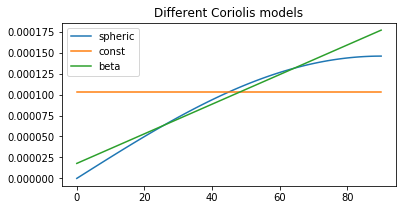

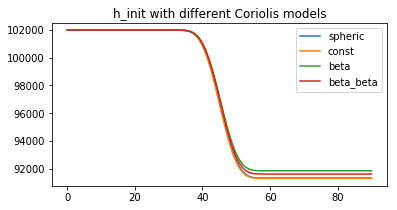

In [4]:
# The three different Coriolis models:

spheric = spheric_coriolis(phi)
const = const_coriolis(phi)
beta_model = beta_coriolis(phi)

fig = plt.figure(figsize=(6,3))
plt.plot(phi*180/np.pi, spheric, label="spheric")
plt.plot(phi*180/np.pi, const, label="const")
plt.plot(phi*180/np.pi, beta_model, label="beta")
plt.legend()
plt.title("Different Coriolis models")

print("max((spheric, const, beta_model)):", (spheric.max(), const.max(), beta_model.max()))
print("min((spheric, const, beta_model)):", (spheric.min(), const.min(), beta_model.min()))

print("midpoint_phi: ", midpoint_phi, spheric_coriolis(midpoint_phi))


#init_h_integral_beta  = lambda lat: RADIUS*init_u(lat)*(beta_coriolis(lat) + (np.tan(lat)/RADIUS)*init_u(lat))
#init_h_integral_const = lambda lat: RADIUS*init_u(lat)*(const_coriolis(lat) + (np.tan(lat)/RADIUS)*init_u(lat))
gh0_beta  = generate_gh0(phi, beta_coriolis, np.tan, phi_0, h_0_guestimate)
gh0_const = generate_gh0(phi, const_coriolis, np.tan, phi_0, h_0_guestimate)
gh0_beta_beta = generate_gh0(phi, beta_coriolis, beta_tan, phi_0, h_0_guestimate)

fig = plt.figure(figsize=(6,3))
plt.plot(phi*180/np.pi, gh0, label="spheric")
plt.plot(phi*180/np.pi, gh0_const, label="const")
plt.plot(phi*180/np.pi, gh0_beta, label="beta")
plt.plot(phi*180/np.pi, gh0_beta_beta, label="beta_beta")
plt.legend()
plt.title("h_init with different Coriolis models")

h_mean = np.mean(gh0_beta)
print("h_mean: ", h_mean)



## Finding the parameter $h_0$

It is defined such that the global mean of $h$ is 10000

In [5]:
h_mean = 10000 # m

# integrand above phi_1:
double_int_above_phi_1 = scipy.integrate.quadrature(init_h_integrand, phi_0, phi_1, 
                                                    args=(beta_coriolis, beta_tan))[0]


def mean_integrand(lat, coriolis_function):
    return np.cos(lat)*scipy.integrate.quadrature(init_h_integrand, phi_0, lat, 
                                                  args=(coriolis_function, beta_tan))[0]


def mean_dbl_integrand(lat, y):
    return np.cos(y)*RADIUS*init_u(lat)*(beta_coriolis(lat) + (beta_tan(lat)/RADIUS)*init_u(lat))

def mean_dbl_integrand_above_phi_1(lat, y):
    return np.cos(y)*double_int_above_phi_1



print("double_int_above_phi_1: ", double_int_above_phi_1)
print("double_int_above_phi_1:  10658.96186949533 (with spherical)")


h_0_analytic = h_mean + (1.0/(2*GRAVITY))*double_int_above_phi_1*(1.0 - np.sin(phi_1) ) + \
               (1.0/(2*GRAVITY))*scipy.integrate.dblquad(mean_dbl_integrand, 
                                                         phi_0, phi_1, # np.pi/2.0,
                                                         lambda x: phi_0*np.ones_like(x), 
                                                         lambda x: x)[0]





print("h_0_guestimate: ", h_0_guestimate)
print("original h_0_analytic: 10152.969251376311")
print("h_0_analytic: ", h_0_analytic)

double_int_above_phi_1:  10371.719810006578
double_int_above_phi_1:  10658.96186949533 (with spherical)
h_0_guestimate:  10400.0
original h_0_analytic: 10152.969251376311
h_0_analytic:  10153.861598779355


## Investigating initial conditions with Cartesian coordinates

In [6]:
distance_between_latitudes = 111e3 # m
distance_equator_north_pole = 10e6

y_0   = distance_between_latitudes*phi_0*180/np.pi
y_1   = distance_between_latitudes*phi_1*180/np.pi
y_mid = distance_between_latitudes*midpoint_phi*180/np.pi


print ("phi_0, phi_1, phi_mid: ", (phi_0, phi_1, midpoint_phi))
print ("degrees_0, degrees_1, degrees_mid: ", (phi_0*180/np.pi, phi_1*180/np.pi, midpoint_phi*180/np.pi))
print ("y_0, y_1, y_mid: ", (y_0, y_1, y_mid))
print ("y_0_rel, y_1_rel, y_mid_rel: ", 
       (y_0/distance_equator_north_pole, y_1/distance_equator_north_pole, y_mid/distance_equator_north_pole))


phi_0, phi_1, phi_mid:  (0.4487989505128276, 1.121997376282069, 0.7853981633974483)
degrees_0, degrees_1, degrees_mid:  (25.714285714285715, 64.28571428571428, 45.0)
y_0, y_1, y_mid:  (2854285.714285714, 7135714.285714286, 4995000.0)
y_0_rel, y_1_rel, y_mid_rel:  (0.2854285714285714, 0.7135714285714286, 0.4995)


In [7]:
# We set the boundary in north and south to be at 10* and 80* north
y_south = 10*distance_between_latitudes
y_north = 80*distance_between_latitudes

ny = 200
dy = (y_north - y_south)/ny
dx = dy
print("(dx, dy): ", (dx, dy))


# Choose the domain to go around the earth (in x-direction)
distance_between_longitudes_45 = 78e3 # m
earth_circumsize_at_midpoint_phi = distance_between_longitudes_45*360
nx = np.floor(earth_circumsize_at_midpoint_phi/dx)
print("(nx, ny): ", (nx, ny))


(dx, dy):  (38850.0, 38850.0)
(nx, ny):  (722.0, 200)


In [8]:
# Timestep
max_dt = 0.25*dx/(np.max(u0 + np.sqrt(gh0)))
dt = 0.8*max_dt
print("max_dt: ", max_dt)
print("dt: ", dt)

max_dt:  24.792269191146694
dt:  19.833815352917355


beta:  1.5910506048511472e-11
y_zero_reference_cell:  44.897959183673464


Text(0.5, 1.0, 'Different Coriolis $\\beta$-models')

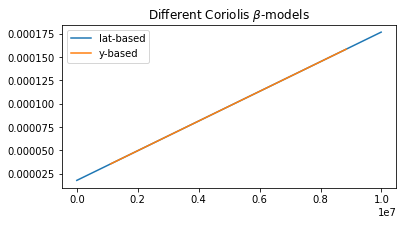

In [9]:
# Our beta model compared to the beta model defined in phi

def our_beta_model(f, beta, cell_id, y_zero_reference_cell, dy):
    return f + beta * (cell_id - y_zero_reference_cell - 0.0)*dy


cells = np.linspace(0,ny-1, ny)
y_zero_reference_cell = (y_0 - y_south)/dy
f0 = spheric_coriolis(phi_0)
beta = (spheric_coriolis(phi_1)-spheric_coriolis(phi_0))/ (y_1 - y_0)  #df/dy
print("beta: ", beta)
print("y_zero_reference_cell: ", y_zero_reference_cell)

fig = plt.figure(figsize=(6,3))
plt.plot(distance_between_latitudes*phi*180/np.pi, beta_model, label="lat-based")
plt.plot(distance_between_latitudes*10 + cells*dy,
         our_beta_model(f0, beta, cells, y_zero_reference_cell, dy),
         label='y-based')
plt.legend()
plt.title(r'Different Coriolis $\beta$-models')



## Resulting steady-state initial conditions

In order to obtain the steady-state initial conditions for 2D Cartesian grids, we

1. Calculate $u_{temp}$ based on the expression for initial $u$ from the paper
2. Calculate initial $h_{init}$ using the expression for $u_{temp}$.
3. Re-calculate initial $u_{init}$ by using the expression for geostrophic balance on the initial $h_{init}$.
4. Obtain $hu_{init} = h_{init} u_{init}$.

sim_phi.shape:  (220,)
sim_u_init.shape:  (220,)
sim_h_init_mean:  9629.02319453221


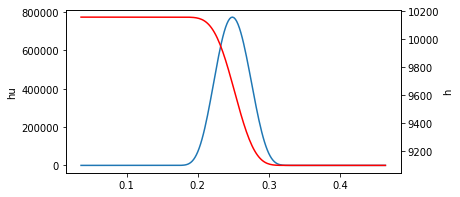

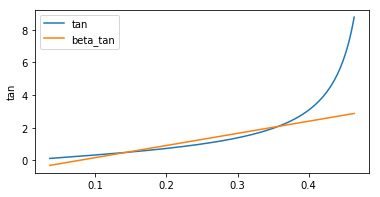

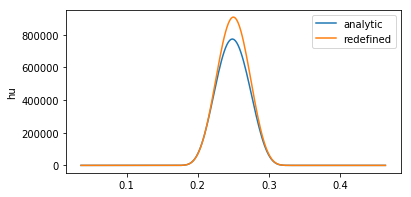

In [10]:
# Define u and H with the above grid resulution 
# These are defined based on phi (with two ghost cells)
# and can be directly put into an array represented by y

phi_south = 10*np.pi/180 # 10 degrees
phi_north = 80*np.pi/180 # 80 degrees
dy_phi = (phi_north - phi_south)/ny
sim_phi = np.linspace(phi_south - 10*dy_phi, phi_north + 10*dy_phi, ny+20)
print("sim_phi.shape: ", sim_phi.shape)

sim_u_init = init_u(sim_phi)
print("sim_u_init.shape: ", sim_u_init.shape)

sim_gh_init = generate_gh0(sim_phi, beta_coriolis, beta_tan, phi_south, h_0_analytic)
sim_h_init = sim_gh_init/GRAVITY

sim_h_init_mean = np.mean(sim_h_init)
print("sim_h_init_mean: ", sim_h_init_mean)

sim_hu_init = sim_u_init*sim_h_init


# Calculate hu which is in geotrophic balance wrt sim_h_init (it's slope is equal to the slope of eta)
redef_hu_init = np.zeros_like(sim_h_init)
for j in range(1, len(redef_hu_init)-1):
    #y0_offset = 32.5
    y0_offset = 10.5 # Compensating for the open boundary, and location of cell centeres.
    redef_hu_init[j] = - (GRAVITY*sim_h_init_mean/our_beta_model(f0, beta, j, y_zero_reference_cell+y0_offset, dy))*\
                    (sim_h_init[j+1]-sim_h_init[j-1])/(2*dy)


fig = plt.figure(figsize=(6,3))
plt.plot(sim_phi/np.pi, sim_hu_init)
plt.ylabel("hu")

plt.twinx()
plt.plot(sim_phi/np.pi, sim_h_init, color='r')
plt.ylabel("h")


fig = plt.figure(figsize=(6,3))
plt.plot(sim_phi/np.pi, np.tan(sim_phi), label='tan')
plt.plot(sim_phi/np.pi, beta_tan(sim_phi), label='beta_tan')
beta_tan
plt.ylabel("tan")
plt.legend()


fig = plt.figure(figsize=(6,3))
plt.plot(sim_phi/np.pi, sim_hu_init, label='analytic')
plt.plot(sim_phi/np.pi, redef_hu_init, label='redefined')
plt.ylabel("hu")
plt.legend()




if False:
    h_syM_check = sim_h_init + sim_h_init[-1::-1]
    fig = plt.figure(figsize=(6,3))
    plt.plot(sim_phi/np.pi, h_syM_check, label='h sym check')
    plt.legend()

    u_syM_check = sim_hu_init - sim_hu_init[-1::-1]
    fig = plt.figure(figsize=(6,3))
    plt.plot(sim_phi/np.pi, u_syM_check, label='u_syM_check')
    plt.legend()

    redef_u_syM_check = redef_hu_init - redef_hu_init[-1::-1]
    fig = plt.figure(figsize=(6,3))
    plt.plot(sim_phi/np.pi, redef_u_syM_check, label='redef_u_syM_check')
    plt.legend()
    

# Perturbation function

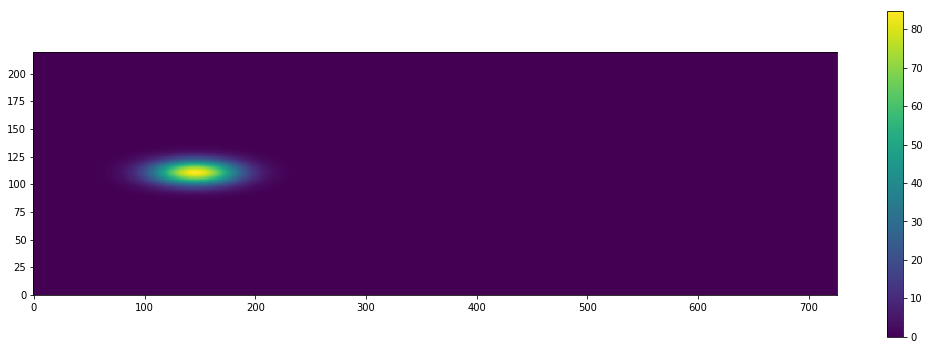

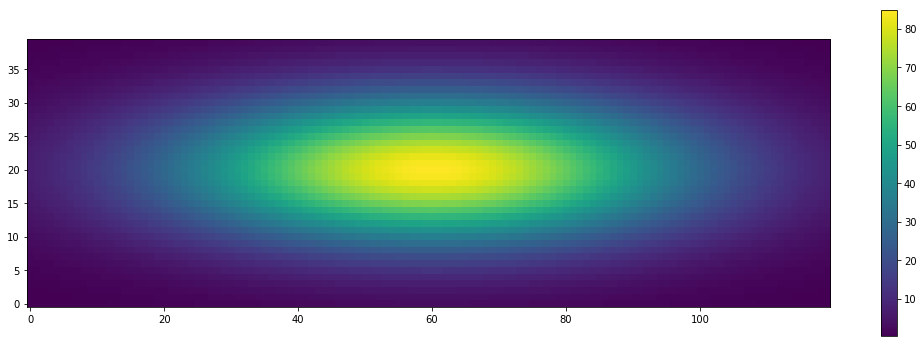

In [23]:
ghosts = np.array([10,2,10,2]) # north, east, south, west
dataShape = (int(ny)+ ghosts[0]+ghosts[2], int(nx)+ ghosts[1]+ghosts[3])
eta_pert = np.zeros(dataShape)

def perturb_eta(eta_pert, ghosts):
    nx = eta_pert.shape[1] - ghosts[1] - ghosts[3]
    ny = eta_pert.shape[0] - ghosts[0] - ghosts[2]
    
    radius_y_cells = distance_between_longitudes_45*180/dx
    mid_cell_y = int(eta_pert.shape[0]/2)
    mid_cell_x = int(nx/5) + ghosts[3]
    pert_alpha = 1/3
    pert_beta = 1/15
    h_hat = 120

    for j in range(ghosts[2], ny+ghosts[2]):
        for i in range(ghosts[3], nx+ghosts[3]):
            
            squared_dist_y = ((1/pert_beta)*(np.pi/180)*(j-mid_cell_y)*dy/distance_between_latitudes)**2
            squared_dist_x = ((1/pert_alpha)*(np.pi/180)*(i-mid_cell_x)*dx/(distance_between_longitudes_45))**2
            
            lat = np.cos(np.pi/4) # approximation into the beta-plane
            

            eta_pert[j,i] += h_hat*lat*np.exp(-squared_dist_y - squared_dist_x)
            
perturb_eta(eta_pert, ghosts)
fig = plt.figure(figsize=(18,6))
plt.imshow(eta_pert, origin='lower', interpolation='none')
plt.colorbar()


fig = plt.figure(figsize=(18,6))
mid_cell_y = int(eta_pert.shape[0]/2)
mid_cell_x = int(nx/5) + ghosts[3]
plt.imshow(eta_pert[mid_cell_y-20:mid_cell_y+20,  mid_cell_x-60:mid_cell_x+60], origin='lower', interpolation='none')
plt.colorbar()

# Set up and animate simulations

In [12]:

# Set initial conditions common to all simulators
sim_args = {
"gpu_ctx": gpu_ctx,
"nx": int(nx), "ny": int(ny),
"dx": dy, "dy": dy,
"dt": dt,
"g": GRAVITY,
"f": f0,
"coriolis_beta": beta,
"r": 0.0,
"y_zero_reference_cell": y_zero_reference_cell
}

eta_max = 1.5
hu_max = 1.5

## Animation function

In [74]:
def sim_animation(simulator, T, plot_dt, crossection=False, spinUp=False, snapshot=False):
    
    #Helper function which simulates and plots the solution
    if spinUp:
        t = sim.step(20*plot_dt*dt)
    
    eta1, hu1, hv1 = sim.download(interior_domain_only=True)
    print("sim.download in sim_animator - eta1.shape: ", eta1.shape)
    
    #Create figure and plot initial conditions
    fig = plt.figure(figsize=(12, 12), constrained_layout=True)
    domain_extent = [0, eta1.shape[1]*sim.dx, 0, eta1.shape[0]*sim.dy]
    y_axis_eta = np.linspace(0.5*sim.dy, (sim.ny+0.5)*sim.dy, eta1.shape[0])
    y_axis_hu  = np.linspace(0.5*sim.dy, (sim.ny+0.5)*sim.dy, hu1.shape[0])
    y_axis_hv  = np.linspace(0.5*sim.dy, (sim.ny+0.5)*sim.dy, hv1.shape[0])
    mid_cell_x = int(eta1.shape[1]/2)
    pert_cell_x = int(eta1.shape[1]/5)
    
    gs = fig.add_gridspec(3,5)
    
    ax_eta = fig.add_subplot(gs[0,0:-2])
    sp_eta = ax_eta.imshow(eta1, interpolation="spline36", origin='bottom', vmin=-eta_max, vmax=eta_max, extent=domain_extent)
    solid_eta  = ax_eta.plot([mid_cell_x*sim.dx, mid_cell_x*sim.dx],   [0, eta1.shape[0]*sim.dy], 'C9-')
    dotted_eta = ax_eta.plot([pert_cell_x*sim.dx, pert_cell_x*sim.dx], [0, eta1.shape[0]*sim.dy], 'C3-.')
    ax_eta.set_title('$\eta$')
    
    ax_u = fig.add_subplot(gs[1,0:-2])
    sp_u = ax_u.imshow(hu1, interpolation="spline36", origin='bottom', vmin=-hu_max, vmax=hu_max, extent=domain_extent)
    solid_u  = ax_u.plot([mid_cell_x*sim.dx, mid_cell_x*sim.dx],   [0, eta1.shape[0]*sim.dy], 'C9-')
    dotted_u = ax_u.plot([pert_cell_x*sim.dx, pert_cell_x*sim.dx], [0, eta1.shape[0]*sim.dy], 'C3-.')
    ax_u.set_title('$hu$')
   
    ax_v = fig.add_subplot(gs[2,0:-2])
    sp_v = ax_v.imshow(hv1, interpolation="spline36", origin='bottom', vmin=-hu_max, vmax=hu_max, extent=domain_extent)
    solid_v  = ax_v.plot([mid_cell_x*sim.dx, mid_cell_x*sim.dx],   [0, eta1.shape[0]*sim.dy], 'C9-')
    dotted_v = ax_v.plot([pert_cell_x*sim.dx, pert_cell_x*sim.dx], [0, eta1.shape[0]*sim.dy], 'C3-.')
    ax_v.set_title('$hv$')
   
    if crossection:
        ax_eta_cs = fig.add_subplot(gs[0,-2:])
        cs_eta_init, = ax_eta_cs.plot(y_axis_eta, eta1[:, mid_cell_x], 'C1--')
        cs_eta,      = ax_eta_cs.plot(y_axis_eta, eta1[:, mid_cell_x], 'C9-' )
        cs_eta_pert, = ax_eta_cs.plot(y_axis_eta, eta1[:, pert_cell_x], 'C3-.')
        ax_eta_cs.set_ylim(-eta_max*1.3, eta_max*1.3)
        ax_eta_cs.grid()
        
        ax_hu_cs = fig.add_subplot(gs[1,-2:])
        cs_hu_init, = ax_hu_cs.plot(y_axis_hu, hu1[:, mid_cell_x], 'C1--')
        cs_hu,      = ax_hu_cs.plot(y_axis_hu, hu1[:, mid_cell_x], 'C9-' )
        cs_hu_pert, = ax_hu_cs.plot(y_axis_hu, hu1[:, pert_cell_x], 'C3-.')
        ax_hu_cs.set_ylim(-hu_max, hu_max)
        ax_hu_cs.grid()
        
        ax_hv_cs = fig.add_subplot(gs[2,-2:])
        cs_hv_init, = ax_hv_cs.plot(y_axis_hv, hv1[:, mid_cell_x], 'C1--')
        cs_hv,      = ax_hv_cs.plot(y_axis_hv, hv1[:, mid_cell_x], 'C9-' )
        cs_hv_pert, = ax_hv_cs.plot(y_axis_hv, hv1[:, pert_cell_x], 'C3-.')
        ax_hv_cs.set_ylim(-hu_max, hu_max)
        ax_hv_cs.grid()
    
    fig.suptitle("Time = {:04.0f} s ({:s})".format(sim.t, sim.__class__.__name__), fontsize=18)
        
    if snapshot:
        return fig
    
    def animate(i):
        if (i>0):
            t = sim.step(plot_dt*dt)
        else:
            t = sim.t
        eta1, hu1, hv1 = sim.download(interior_domain_only=True)
        
        #Update plots
        fig.sca(ax_eta)
        sp_eta.set_data(eta1)
        
        fig.sca(ax_u)
        sp_u.set_data(hu1)
        
        fig.sca(ax_v)
        sp_v.set_data(hv1)
        
        if crossection:
            cs_eta.set_data(y_axis_eta, eta1[:, mid_cell_x])
            cs_hu.set_data(y_axis_hu,    hu1[:, mid_cell_x])
            cs_hv.set_data(y_axis_hv,    hv1[:, mid_cell_x])
            cs_eta_pert.set_data(y_axis_eta, eta1[:, pert_cell_x])
            cs_hu_pert.set_data(y_axis_hu,    hu1[:, pert_cell_x])
            cs_hv_pert.set_data(y_axis_hv,    hv1[:, pert_cell_x])
        
        fig.suptitle("Time = {:04.0f} s ({:s})".format(t, sim.__class__.__name__), fontsize=18)
        print("."+str(i)+".", end='')

    #Matplotlib for creating an animation
    anim = animation.FuncAnimation(fig, animate, range(T), interval=100)
    plt.close(fig)
    return anim

# Steady-state solution for CDKLM

Steady state is maintained for a long simulation time

sim_h_init.shape:  (220,)
eta0.shape (220, 726)
(ny, nx):  (200, 722)
max eta and hu:  (532.8359, 1088927.775)
sim_args['y_zero_reference_cell']:  44.897959183673464
self.interior_domain_indices: [-10  -2  10   2]
sim.download in sim_animator - eta1.shape:  (200, 722)
sim.download in sim_animator - eta1.shape:  (200, 722)
.0..0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79.sim.download in sim_animator - eta1.shape:  (200, 722)
.0..0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78

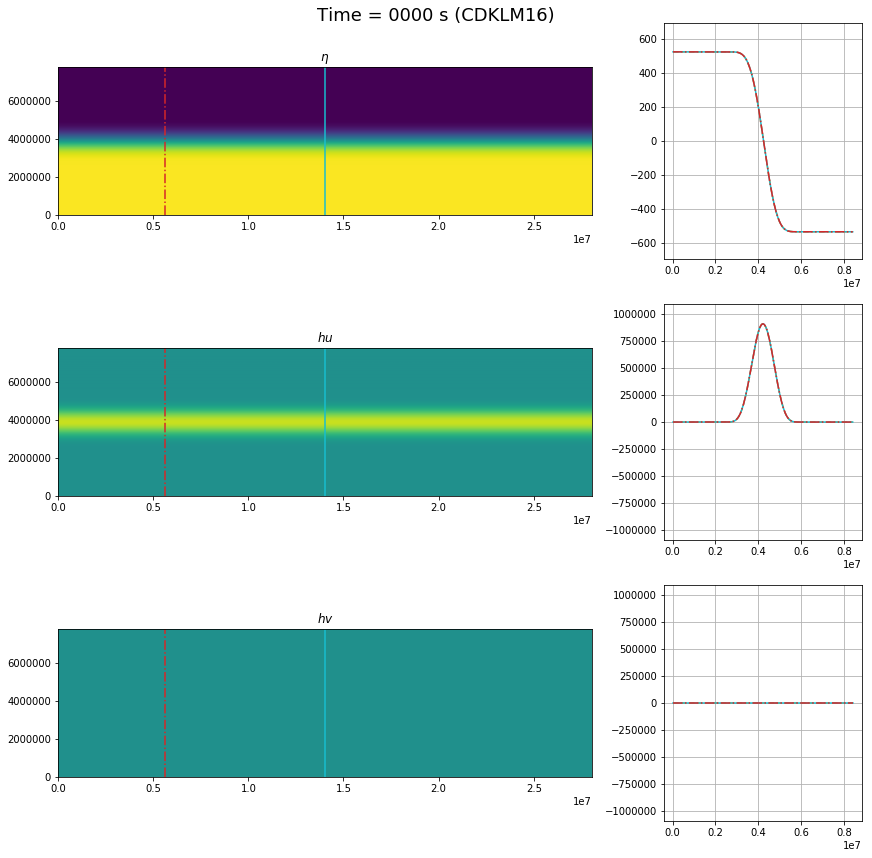

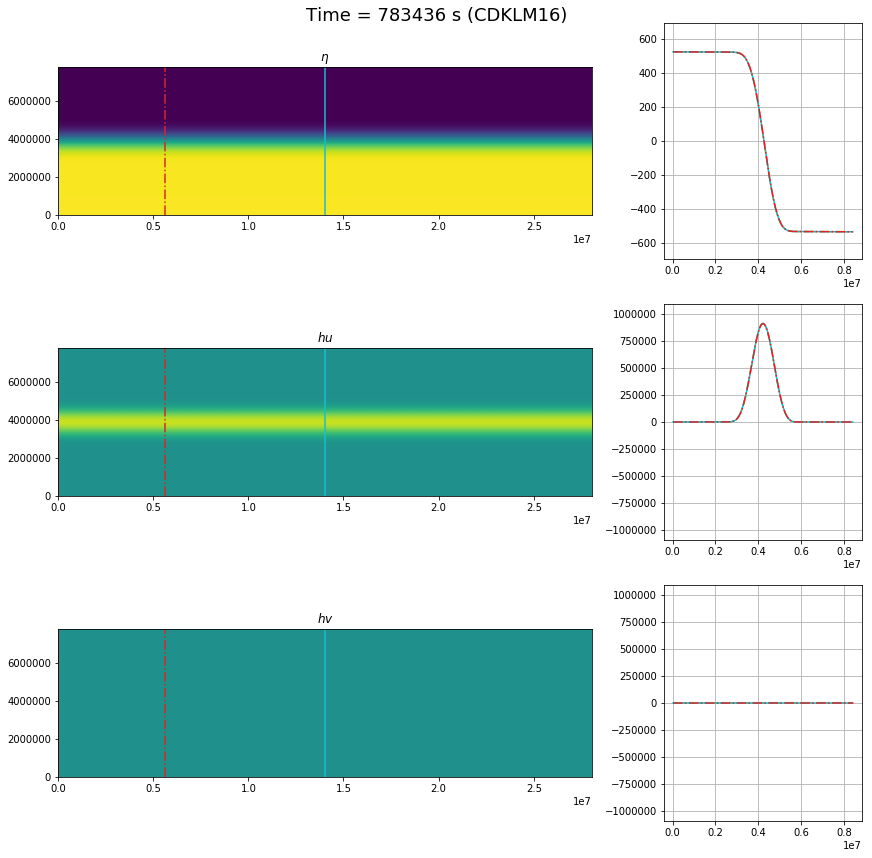

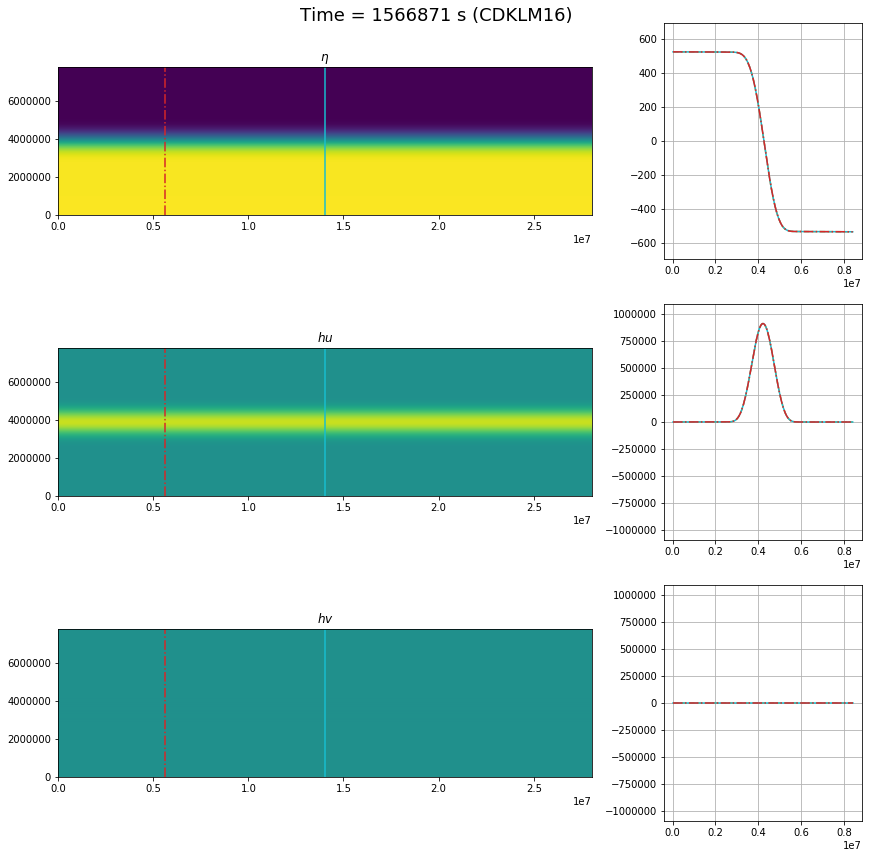

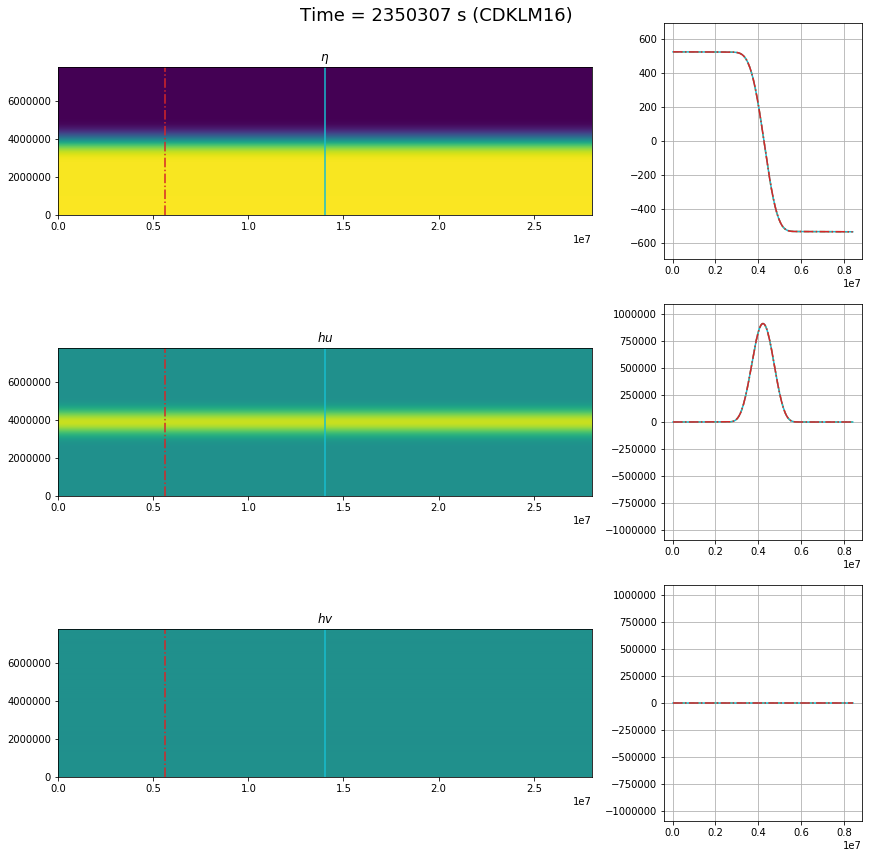

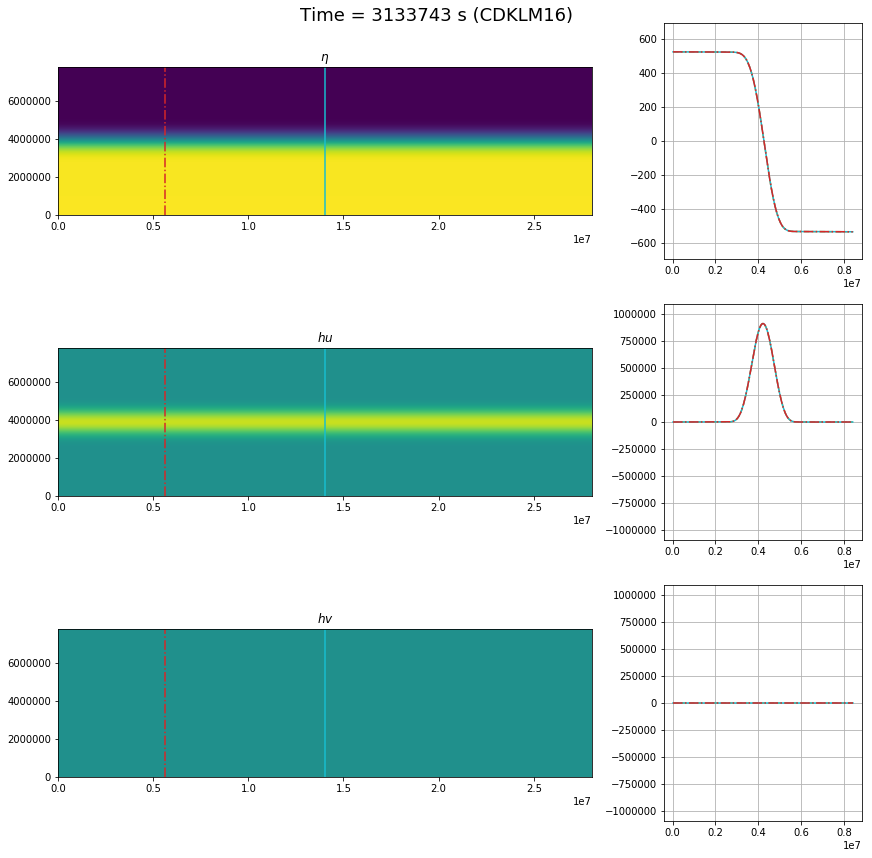

In [79]:
if 'sim' in globals():
    sim.cleanUp()
reload(CDKLM16)
    
ghosts = np.array([10,2,10,2]) # north, east, south, west
dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])

H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * sim_h_init_mean
eta0 = -np.ones(dataShape, dtype=np.float32) * sim_h_init_mean
u0 = np.zeros(dataShape, dtype=np.float32)
v0 = np.zeros(dataShape, dtype=np.float32)

print("sim_h_init.shape: ", sim_h_init.shape)
print("eta0.shape", eta0.shape)
print("(ny, nx): ", (sim_args["ny"], sim_args["nx"]))

for i in range(dataShape[1]):
    eta0[:,i] += sim_h_init
    u0[:,i] = redef_hu_init

eta_max = np.max(np.abs(eta0))
hu_max = np.max(np.abs(u0))*1.2
print("max eta and hu: ", (eta_max, hu_max))

#Create perturbation
#perturb_eta(eta0, ghosts)

#Initialize simulator
cdklm_args = {"H": H, "eta0": eta0, "hu0": u0, "hv0": v0, "rk_order": 2,
              "boundary_conditions": Common.BoundaryConditions(3,2,3,2, spongeCells=[10,2,10,2])}
print("sim_args['y_zero_reference_cell']: ", sim_args['y_zero_reference_cell'])
sim = CDKLM16.CDKLM16(**cdklm_args, **sim_args)

#Run a simulation and plot it
#sim_animation(sim, T=20, plot_dt=100,  crossection=True)
#anim = sim_animation(sim, T=70, plot_dt=500, crossection=True, spinUp=False)
#anim = sim_animation(sim, T=70, plot_dt=500, crossection=True, spinUp=False)

# init
cdklm_galewsky_steady_anim = sim_animation(sim, T=80, plot_dt=500, crossection=True, spinUp=False)
# plot
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

# run, animate and save
cdklm_galewsky_steady_anim.save('steady_galewsky_cdklm_1.mp4')
# plot
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

# run, animate and save
cdklm_galewsky_steady_anim.save('steady_galewsky_cdklm_2.mp4')
# plot
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

# run, animate and save
cdklm_galewsky_steady_anim.save('steady_galewsky_cdklm_3.mp4')
# plot
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

# run, animate and save
cdklm_galewsky_steady_anim.save('steady_galewsky_cdklm_4.mp4')
# plot
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)
print("Done")



# Gravitational wave - CDKLM

We see the gravitational wave leave the domain, and the state becomes (appearantly) steady. Instabilities starts to be visible after twice the simulation $t = $ 300 000 s (currently, simulation time is only for half this time)

sim_h_init.shape:  (220,)
eta0.shape (220, 726)
(ny, nx):  (200, 722)
max eta and hu:  (532.8359, 1088927.775)
sim_args['y_zero_reference_cell']:  44.897959183673464
self.interior_domain_indices: [-10  -2  10   2]
sim.download in sim_animator - eta1.shape:  (200, 722)
sim.download in sim_animator - eta1.shape:  (200, 722)
.0..0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79.sim.download in sim_animator - eta1.shape:  (200, 722)
.0..0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78

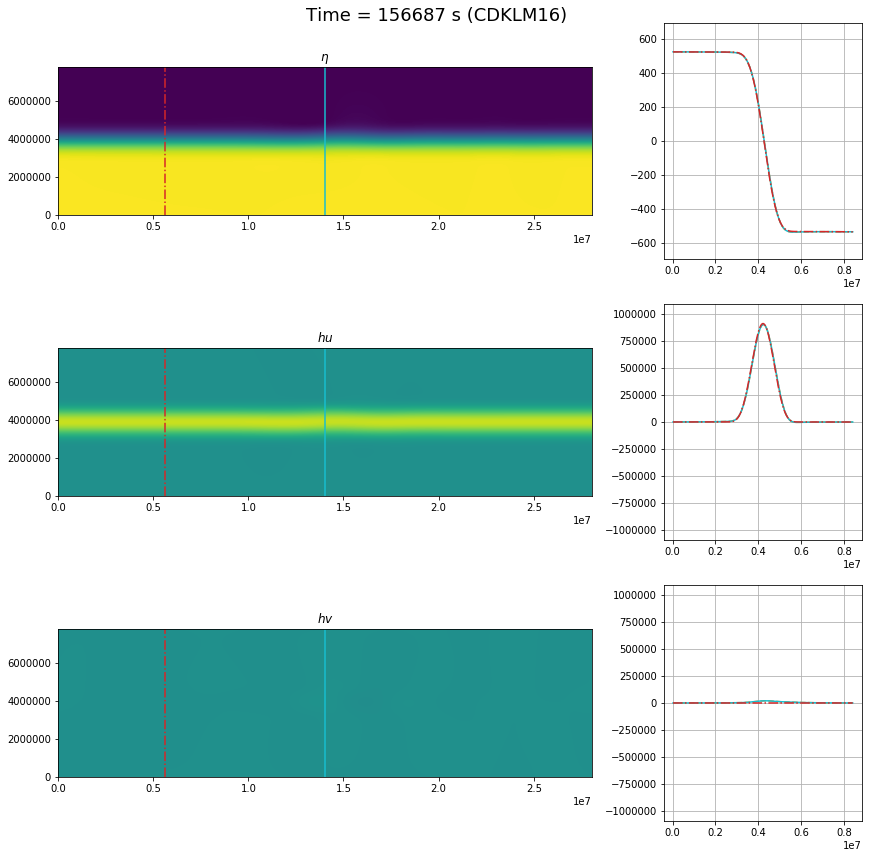

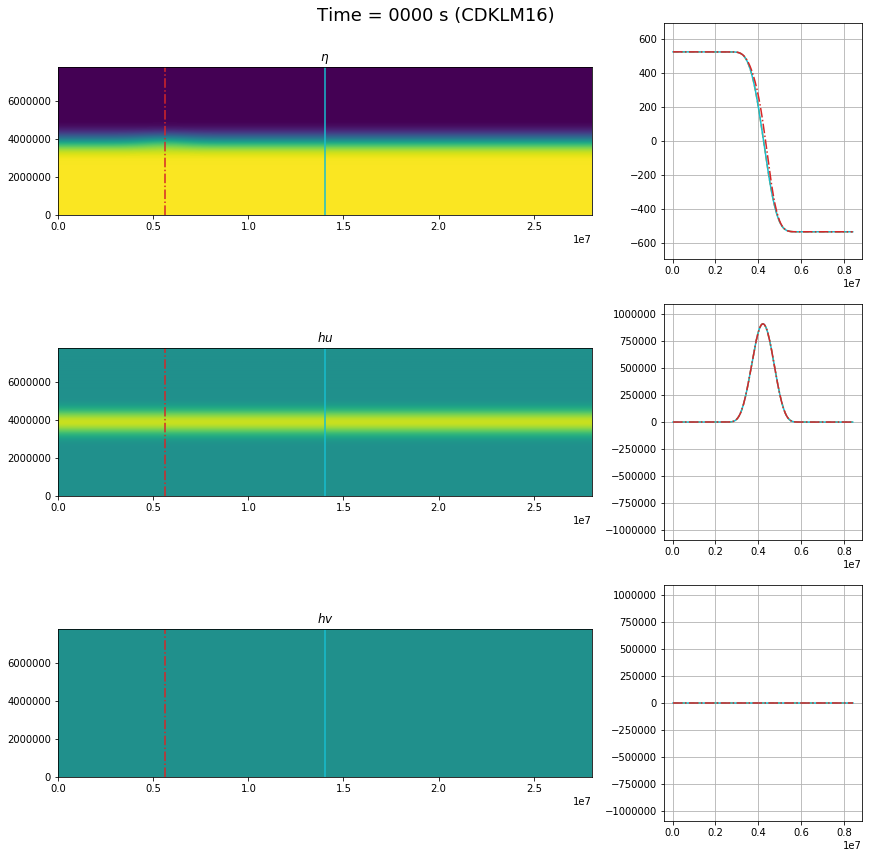

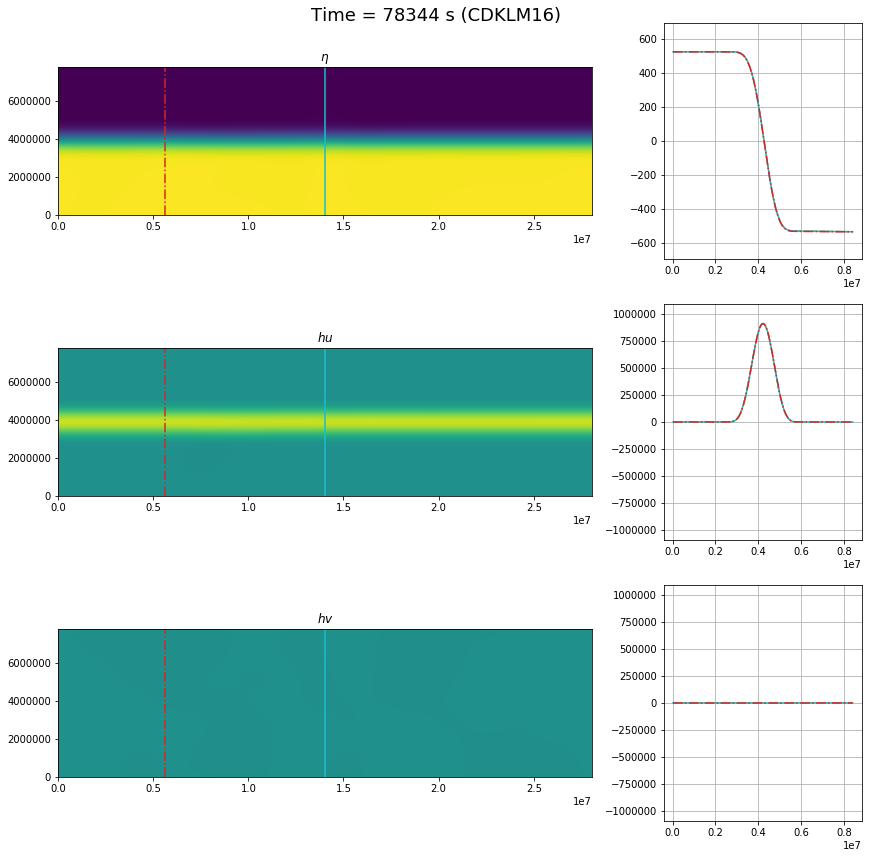

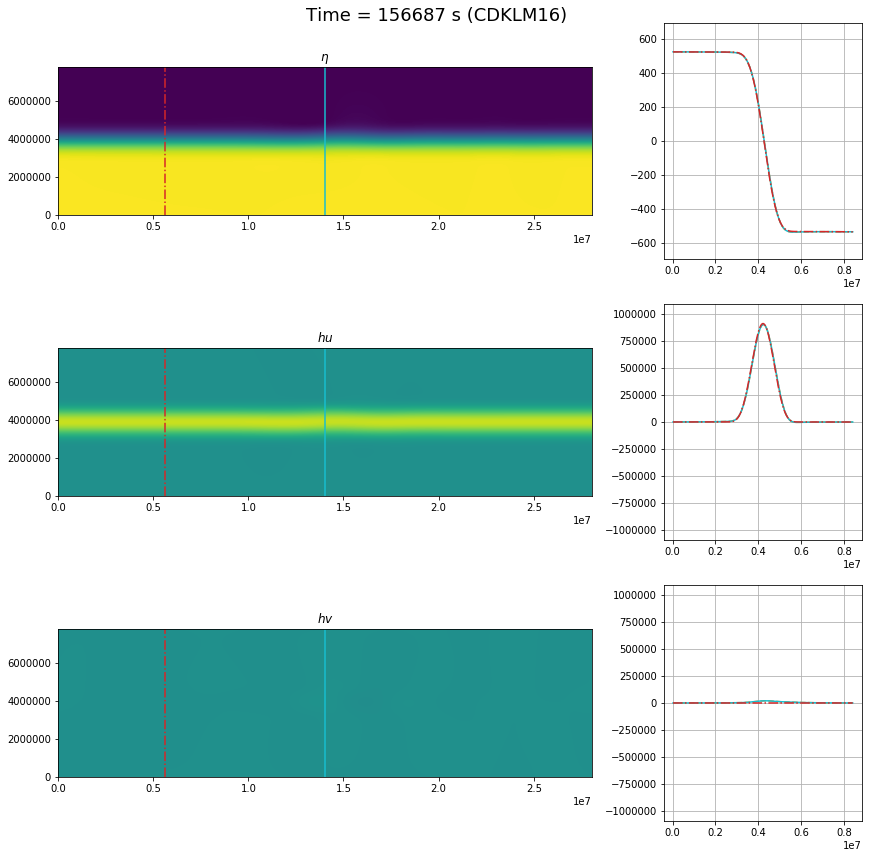

In [77]:
if 'sim' in globals():
    sim.cleanUp()
reload(CDKLM16)
    
ghosts = np.array([10,2,10,2]) # north, east, south, west
dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])

H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * sim_h_init_mean
eta0 = -np.ones(dataShape, dtype=np.float32) * sim_h_init_mean
u0 = np.zeros(dataShape, dtype=np.float32)
v0 = np.zeros(dataShape, dtype=np.float32)

print("sim_h_init.shape: ", sim_h_init.shape)
print("eta0.shape", eta0.shape)
print("(ny, nx): ", (sim_args["ny"], sim_args["nx"]))

for i in range(dataShape[1]):
    eta0[:,i] += sim_h_init
    u0[:,i] = redef_hu_init

eta_max = np.max(np.abs(eta0))
hu_max = np.max(np.abs(u0))*1.2
print("max eta and hu: ", (eta_max, hu_max))

#Create perturbation
perturb_eta(eta0, ghosts)

#Initialize simulator
cdklm_args = {"H": H, "eta0": eta0, "hu0": u0, "hv0": v0, "rk_order": 2,
              "boundary_conditions": Common.BoundaryConditions(3,2,3,2, spongeCells=[10,2,10,2])}
print("sim_args['y_zero_reference_cell']: ", sim_args['y_zero_reference_cell'])
sim = CDKLM16.CDKLM16(**cdklm_args, **sim_args)



#Run a simulation and plot it
# init
cdklm_gravity_anim = sim_animation(sim, T=80, plot_dt=50,  crossection=True)
# plot
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

# run and save
cdklm_gravity_anim.save('gravity_galewsky_cdklm_1.mp4')
# plot
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

# run and save
cdklm_gravity_anim.save('gravity_galewsky_cdklm_2.mp4')
# plot
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)


#sim_animation(sim, T=30, plot_dt=50,  crossection=True)
#sim_animation(sim, T=90, plot_dt=500, crossection=True, spinUp=True)
print("done")


# Long term instability - CDKLM

We observe the instabilities in this long running simulation.

sim_h_init.shape:  (220,)
eta0.shape (220, 726)
(ny, nx):  (200, 722)
max eta and hu:  (532.8359, 1088927.775)
sim_args['y_zero_reference_cell']:  44.897959183673464
self.interior_domain_indices: [-10  -2  10   2]
sim.download in sim_animator - eta1.shape:  (200, 722)
sim.download in sim_animator - eta1.shape:  (200, 722)
.0..0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79.sim.download in sim_animator - eta1.shape:  (200, 722)
.0..0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78

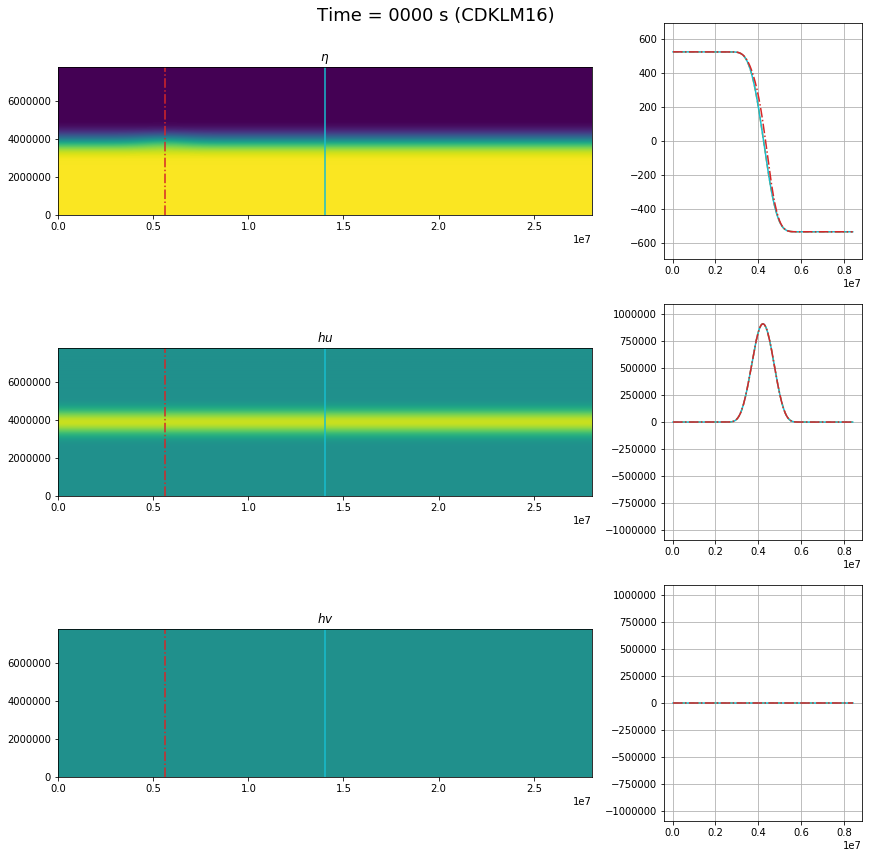

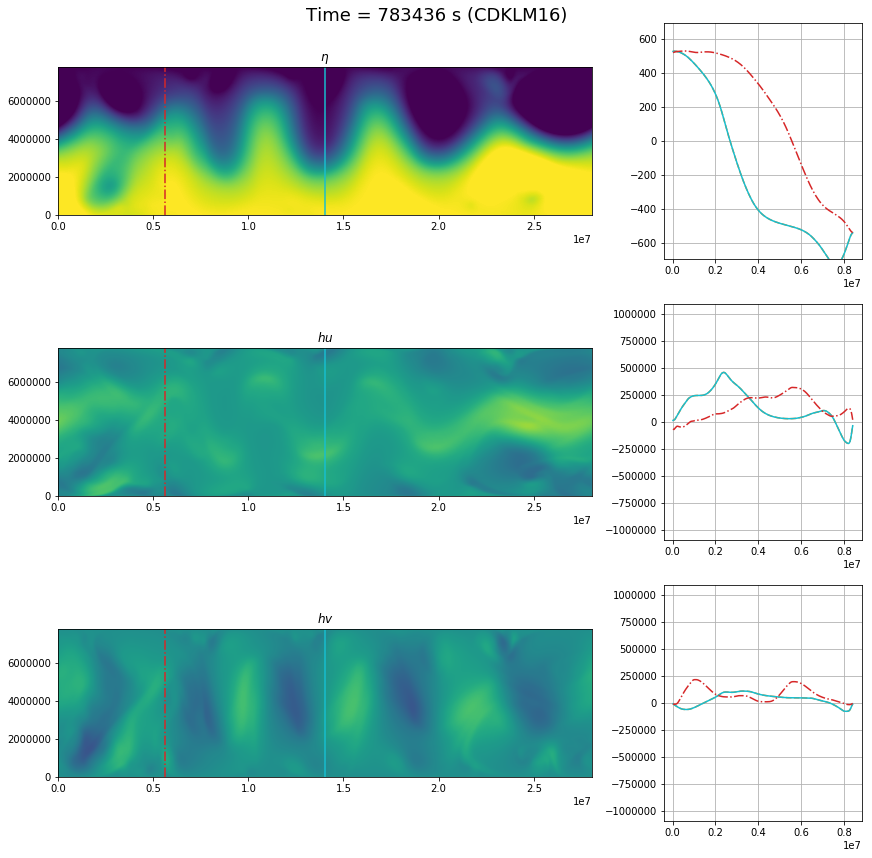

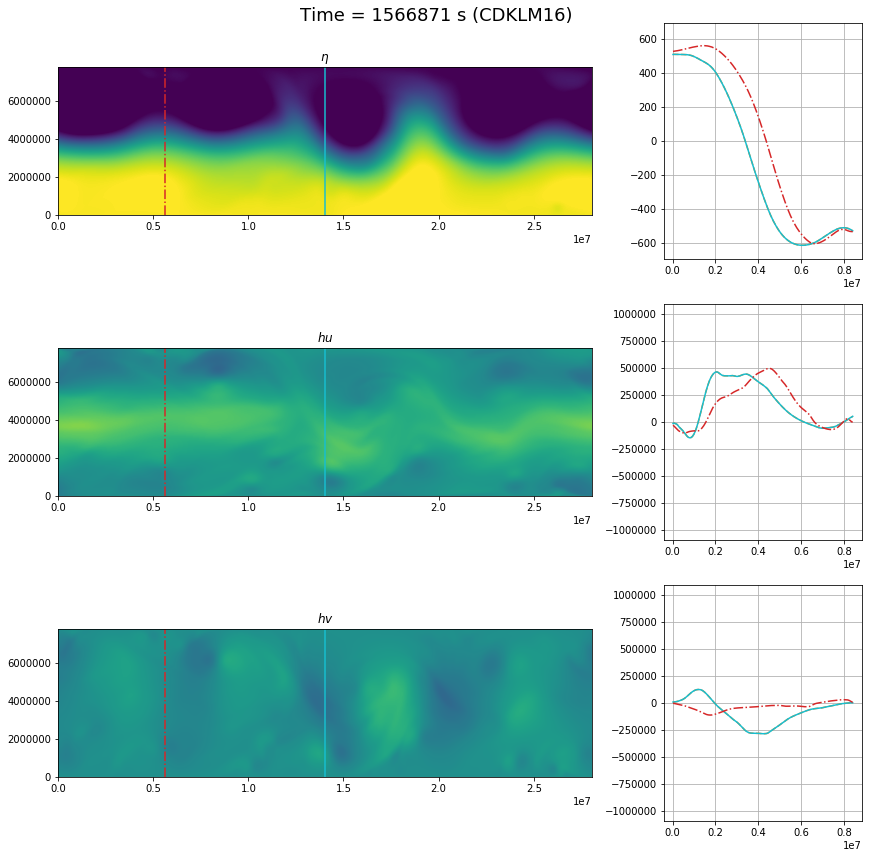

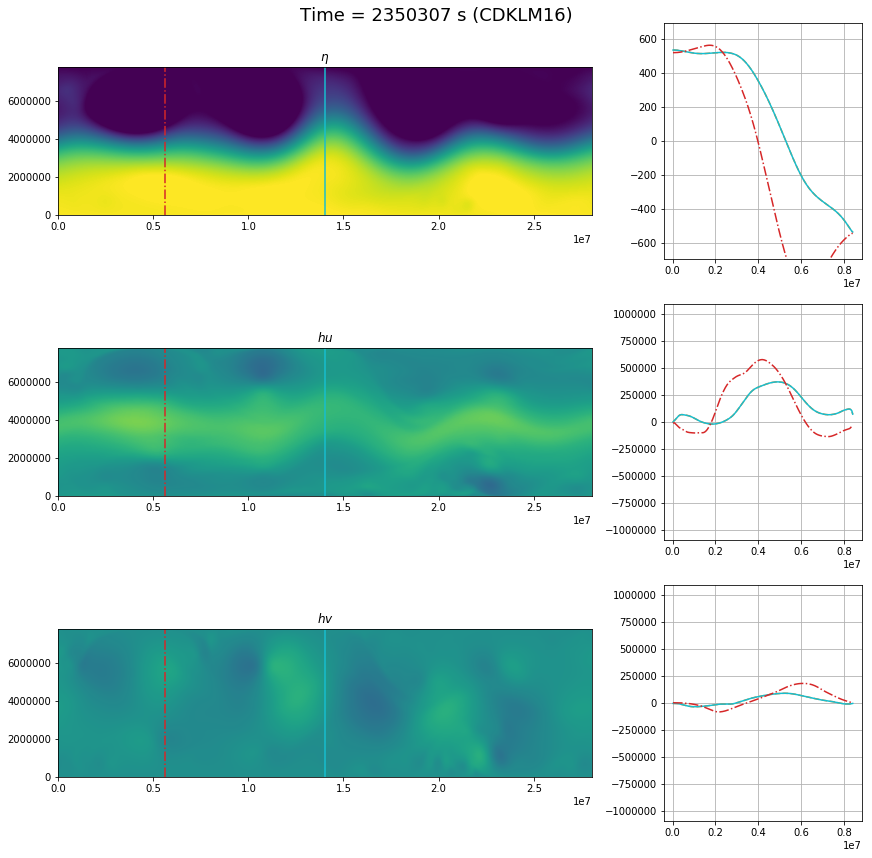

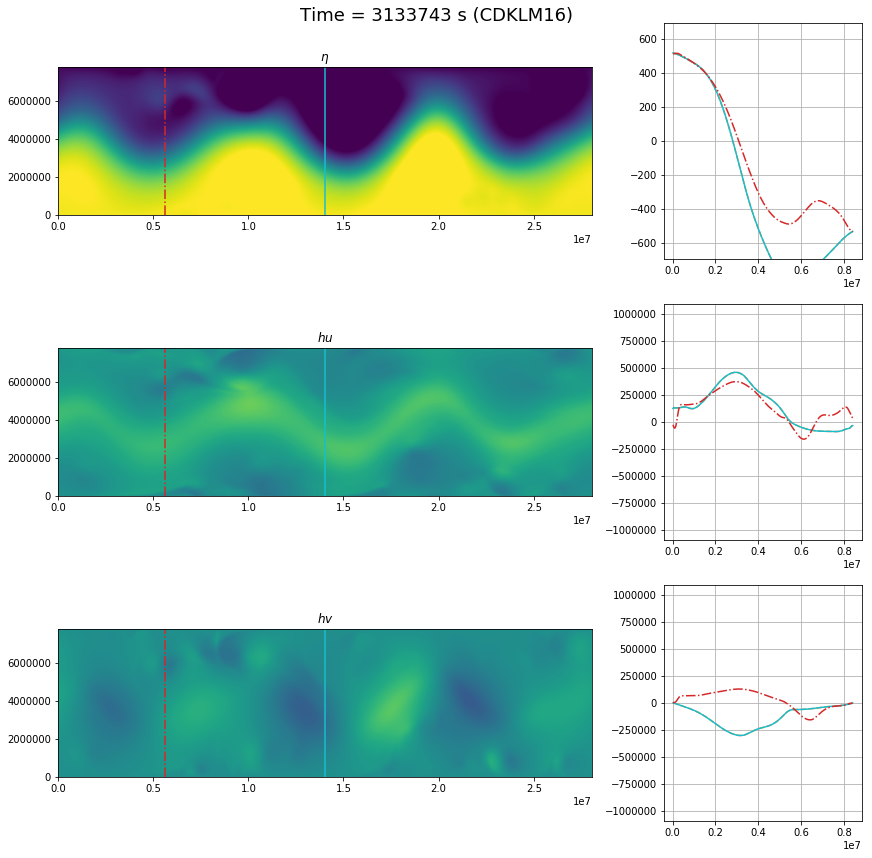

In [76]:
if 'sim' in globals():
    sim.cleanUp()
reload(CDKLM16)
    
ghosts = np.array([10,2,10,2]) # north, east, south, west
dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])

H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * sim_h_init_mean
eta0 = -np.ones(dataShape, dtype=np.float32) * sim_h_init_mean
u0 = np.zeros(dataShape, dtype=np.float32)
v0 = np.zeros(dataShape, dtype=np.float32)

print("sim_h_init.shape: ", sim_h_init.shape)
print("eta0.shape", eta0.shape)
print("(ny, nx): ", (sim_args["ny"], sim_args["nx"]))

for i in range(dataShape[1]):
    eta0[:,i] += sim_h_init
    u0[:,i] = redef_hu_init

eta_max = np.max(np.abs(eta0))
hu_max = np.max(np.abs(u0))*1.2
print("max eta and hu: ", (eta_max, hu_max))

#Create perturbation
perturb_eta(eta0, ghosts)

#Initialize simulator
cdklm_args = {"H": H, "eta0": eta0, "hu0": u0, "hv0": v0, "rk_order": 2,
              "boundary_conditions": Common.BoundaryConditions(3,2,3,2, spongeCells=[10,2,10,2])}
print("sim_args['y_zero_reference_cell']: ", sim_args['y_zero_reference_cell'])
sim = CDKLM16.CDKLM16(**cdklm_args, **sim_args)

#Run a simulation and plot it
#sim_animation(sim, T=20, plot_dt=100,  crossection=True)

# init
cdklm_galewsky_anim = sim_animation(sim, T=80, plot_dt=500, crossection=True, spinUp=False)
# plot
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

# run, animate and save
cdklm_galewsky_anim.save('galewsky_cdklm_1.mp4')
# plot
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

# run, animate and save
cdklm_galewsky_anim.save('galewsky_cdklm_2.mp4')
# plot
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

# run, animate and save
cdklm_galewsky_anim.save('galewsky_cdklm_3.mp4')
# plot
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

# run, animate and save
cdklm_galewsky_anim.save('galewsky_cdklm_4.mp4')
# plot
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)
print("Done")

# Long term instability - CTCS

Instabilitis in CTCS generates very strong eddies when they enter the Flow Relaxation zone, and these eddies dominate the solution. There are very few similarities between the CTCS results and the CDKLM results.

sim_h_init.shape:  (220,)
eta0.shape (220, 724)
(ny, nx):  (200, 722)
max eta and hu:  (532.8359, 1088927.775)
self.interior_domain_indices: [-10  -1  10   1]
sim.download in sim_animator - eta1.shape:  (200, 722)
sim.download in sim_animator - eta1.shape:  (200, 722)
.0..0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79.sim.download in sim_animator - eta1.shape:  (200, 722)
.0..0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79.sim.download in sim_animator - eta1.shape:  (200, 

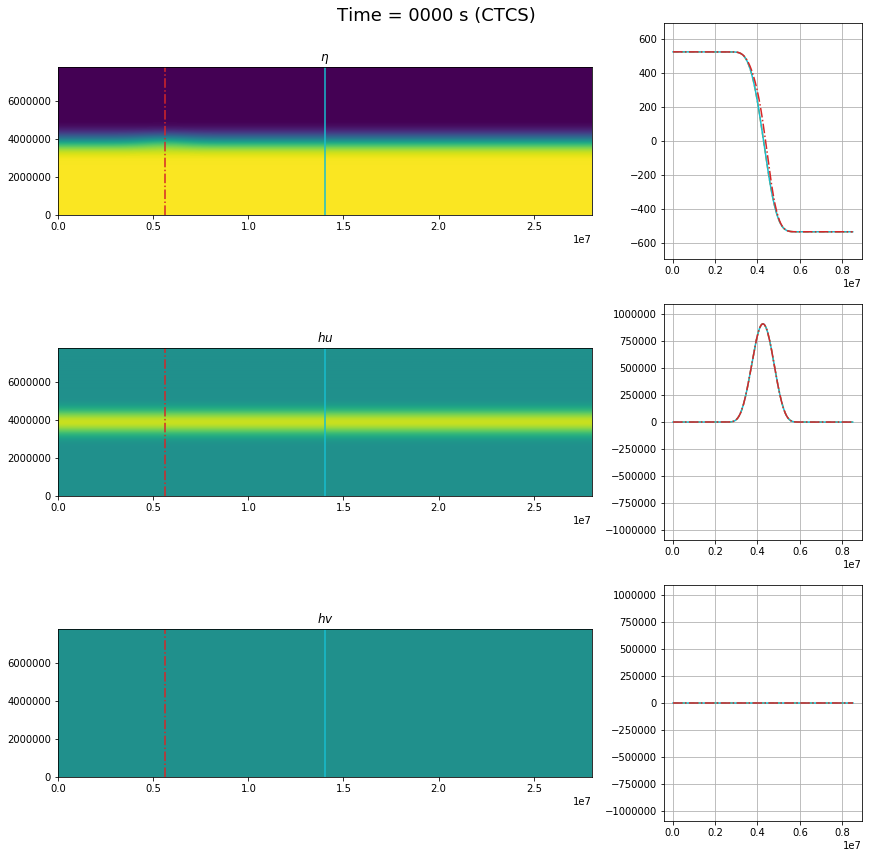

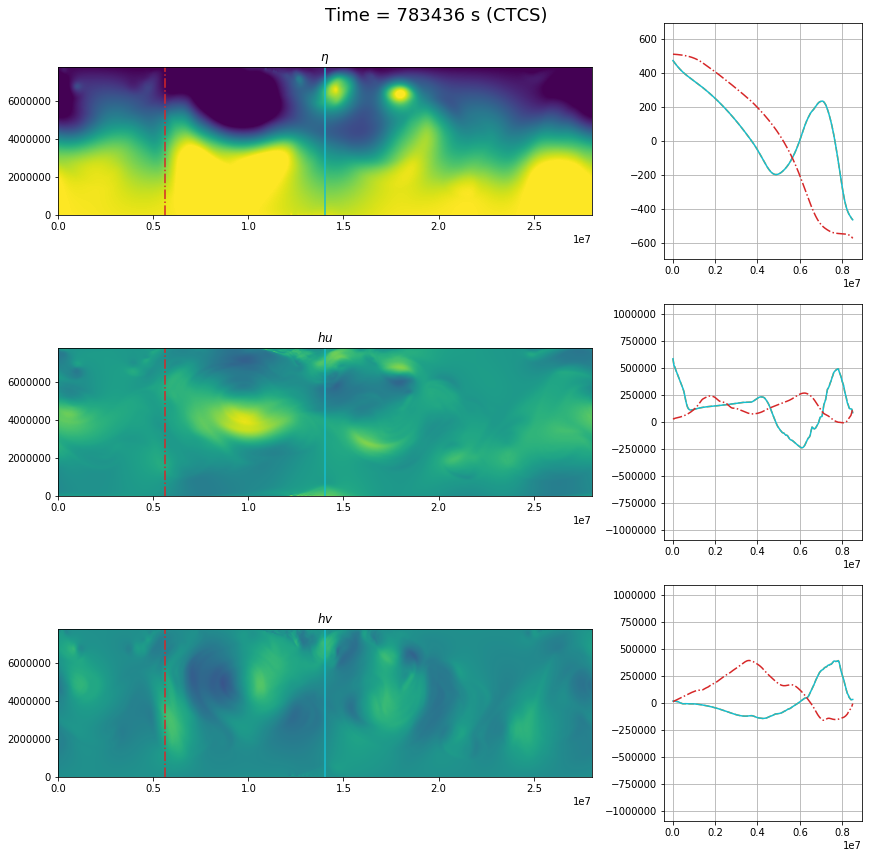

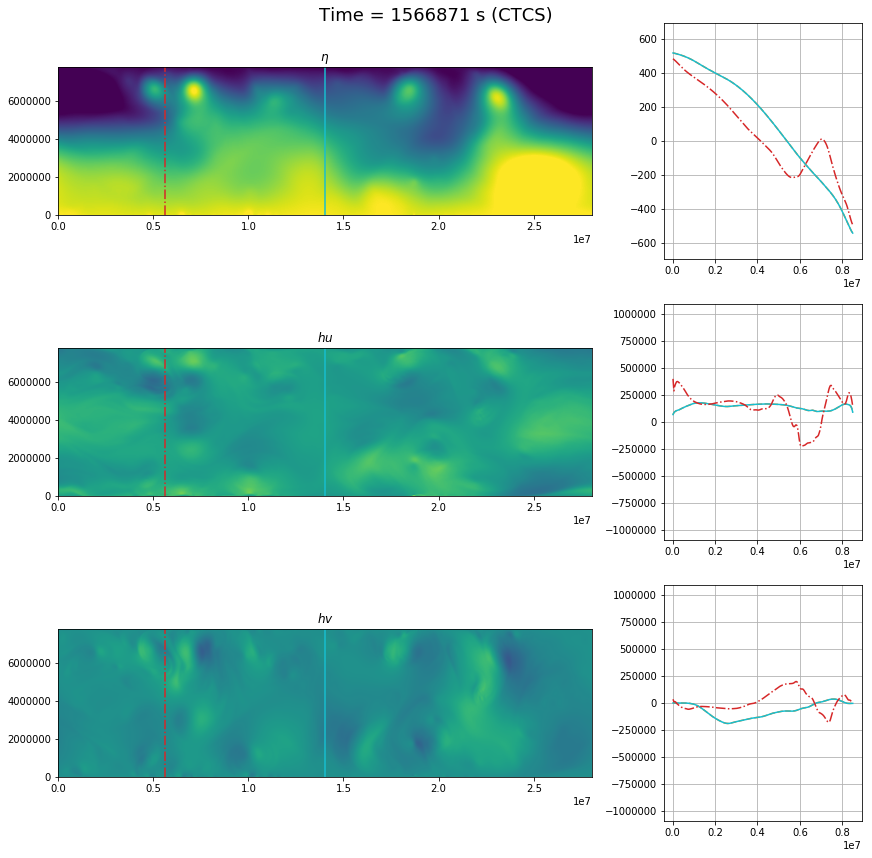

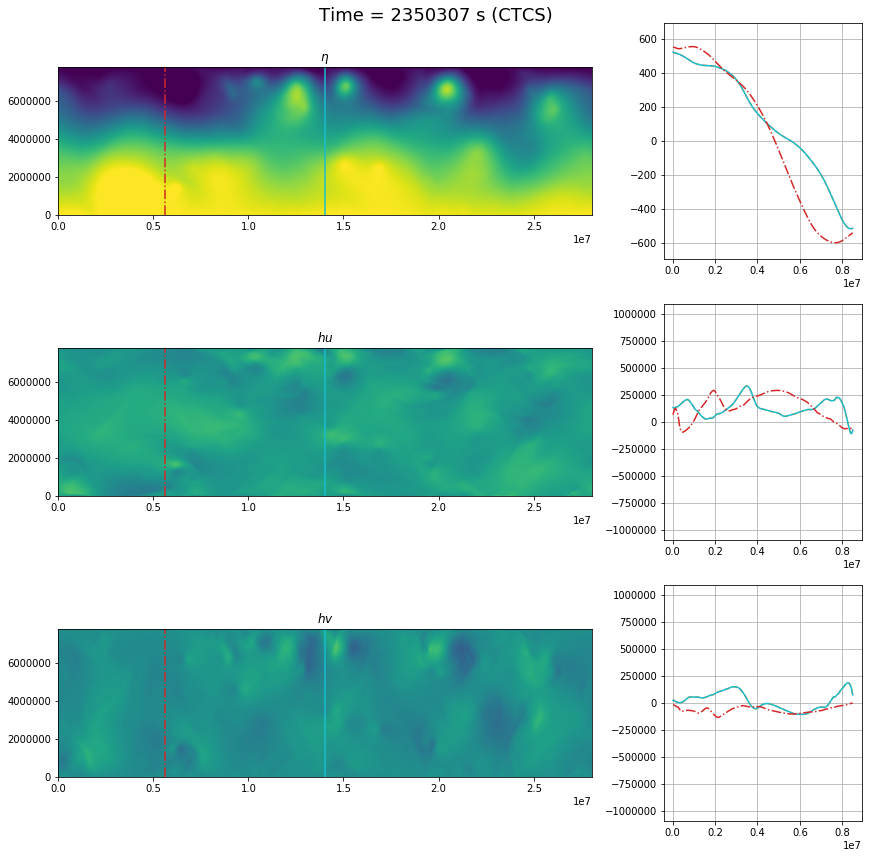

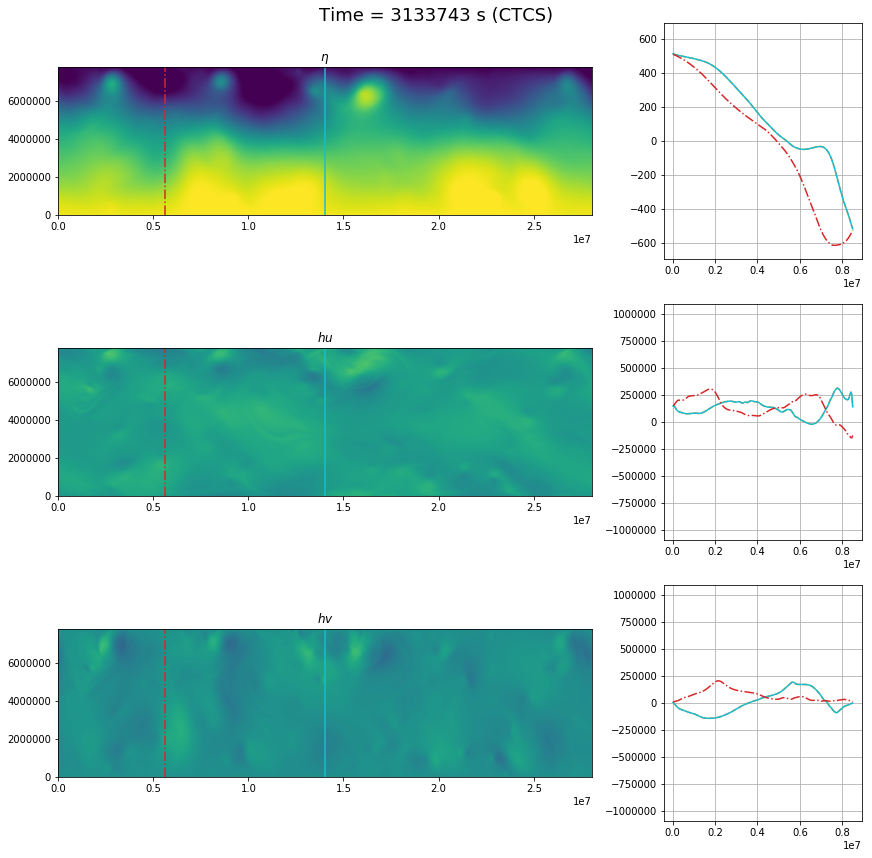

In [78]:
if 'sim' in globals():
    sim.cleanUp()

ghosts = np.array([10,1,10,1]) # north, east, south, west
dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])

h0 = np.ones(dataShape, dtype=np.float32) * sim_h_init_mean
eta0 = -np.ones(dataShape, dtype=np.float32) * sim_h_init_mean;
u0 = np.zeros((dataShape[0], dataShape[1]+1), dtype=np.float32);
v0 = np.zeros((dataShape[0]+1, dataShape[1]), dtype=np.float32);  

print("sim_h_init.shape: ", sim_h_init.shape)
print("eta0.shape", eta0.shape)
print("(ny, nx): ", (sim_args["ny"], sim_args["nx"]))

for i in range(dataShape[1]):
    eta0[:,i] += sim_h_init
    u0[:,i] = redef_hu_init
    #u0[:,i] = sim_hu_init

eta_max = np.max(np.abs(eta0))
hu_max = np.max(np.abs(u0))*1.2
print("max eta and hu: ", (eta_max, hu_max))
    
#Create perturbation
perturb_eta(eta0, ghosts)
    
#Initialize simulator
ctcs_args = {"H": h0, "eta0": eta0, "hu0": u0, "hv0": v0, "A": 10000.0,
             "boundary_conditions": Common.BoundaryConditions(3,2,3,2, spongeCells=[10,1,10,1])}
sim = CTCS.CTCS(**ctcs_args, **sim_args)

#Run a simulation and plot it
#sim_animation(sim, T=20, plot_dt=100,  crossection=True)
ctcs_galewsky_anim = sim_animation(sim, T=80, plot_dt=500, crossection=True, spinUp=False)
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

ctcs_galewsky_anim.save('galewsky_ctcs_1.mp4')
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

ctcs_galewsky_anim.save('galewsky_ctcs_2.mp4')
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

ctcs_galewsky_anim.save('galewsky_ctcs_3.mp4')
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

ctcs_galewsky_anim.save('galewsky_ctcs_4.mp4')
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)
print("Done")